# Exercise
This week the assignment is to take the `startups_profit.csv` file and perform a variety of tasks in order to achieve the desired results. These are as follows:
1. Create a regression model that can predict profit
2. Report relevant metrics for this type of model
3. Tune Hyperparameters with cross-fold validation

I intend on using PyTorch to become more famliar with the library and to aid the process of tuning my Semester Project to achieve the desired accuracy.

In [1]:
import pandas as pd, numpy as np, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt

base_path = Path()
profit_file = base_path.joinpath('startups_profit.csv')
profit_df = pd.read_csv(profit_file, skipinitialspace=True)
profit_df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,"$192,261.83"
1,162597.70,151377.59,443898.53,California,"$191,792.06"
2,153441.51,101145.55,407934.54,FL,"$191,050.39"
3,144372.41,118671.85,383199.62,New York,"$182,901.99"
4,142107.34,91391.77,366168.42,FL,"$166,187.94"


# Transforming the data
Before I subclass the datasets or build any models, first I want to transform the data how I need it to perform analysis. This involes the following steps:
1. First I take the profit column of the data and strip all `$` or `,` characters by replacing them with nothing. During this process I reformat the data as a float value
2. Next I create a copy of the original data - to preserve its integrity as I make further transformations.
3. I scale the new dataframe on a standard curve - this gives me a reformatted set of columns that create a standard distribution. This will improve model accuracy.

In [2]:
profit_df['Profit'] = profit_df['Profit'].str.replace('[$,]', '').astype(float)
scaled_df = profit_df.copy()
numerical_columns = scaled_df.drop(columns=['State'])
scaler = StandardScaler().fit_transform(numerical_columns)
scaled_df[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']] = scaler

scaled_df.head()

C:\Users\sebas\AppData\Local\Temp\ipykernel_30056\1392422914.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  profit_df['Profit'] = profit_df['Profit'].str.replace('[$,]', '').astype(float)


,R&D Spend,Administration,Marketing Spend,State,Profit
0,2.016411,0.560753,2.153943,New York,2.011203
1,1.955860,1.082807,1.923600,California,1.999430
2,1.754364,-0.728257,1.626528,FL,1.980842
3,1.554784,-0.096365,1.422210,New York,1.776627
4,1.504937,-1.079919,1.281528,FL,1.357740


# Creating a dataset
Before I can create a model, first I have to further transform the data to make it usable in PyTorch. This means I have to subclass the dataset. I did so in the following steps:
1. First I created two values, an `X` value comprised of the spending columns and a `y` value comprised of the profit values
2. Next I had to take the States column and encode it to numbers. I did this with a One-Hot encoding method to create a matrix of True (1) or False (0) values. 
3. Now that I have the matrix I don't need the state column so I drop it.
4. Finally I have to transform them into the datatype that PyTorch uses, so I cast them into a tensor with a float datatype. 

#### Note
In this class I have the `__len__` and `__getitem__` methods. These are needed for the dataset functions to subsection the data into the batches. It looks at the length of the dataset, and attempts to create equal length batches by looking at `__len__` then populates those batches by iterating over the dataset with `__getitem__`. 

In [12]:
# Define the PyTorch dataset
class ProfitDataset(Dataset):
    def __init__(self, data):
        self.X = data[['R&D Spend', 'Administration', 'Marketing Spend']]
        self.y = data['Profit'].values
        
        # Convert the categorical variable to one-hot encoding
        states = pd.get_dummies(data['State'])
        self.X = pd.concat([data, states], axis=1).drop(columns=['State']).values
        # Convert the data to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_df, test_size=0.2, random_state=42)

# Instantiate the datasets and dataloaders
train_dataset = ProfitDataset(train_data)
test_dataset = ProfitDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)


# Defining the model
Now that I have the dataset I have to create the model. The model is comprised of a few things, and as a whole is a subclass of the `nn.Module` class which represents all network models in PyTorch. There are two parts to this that I will cover in detail, the `__init__` portion and the `forward` porton.
1. The `__init__` method defines the structure of the neural network. Each layer is outlined below:
   1. `nn.Linear` is used to take the input features and produces an output according to the specific linear layer in question. `fc1` produces a number of outputs equal to the `hidden_size` whereas `fc2` takes the `hidden_size` and produces a number of outputs equal to the `output_size`
   2. `nn.ReLU` is used to introduce non-linearity in the model. It does so by taking each element and applying the function `max(0,x)` to it. In a sense it replaces all negative values to zero and keeps all positive values unchanged. 
2. The `forward` method defines how the forward pass of the neural network will operate. In my case the following occurs:
   1. `X` is passed through the first layer `self.fc1` to create our hidden layer, which is stored in the out.
   2. The `out` tensor is then passed to the `self.relu` layer of the model, which is again stored in the out variable.
   3. Lastly the `out` tensor is passed through the last linear layer `self.fc2` to produce the final output which is returned. 

In [34]:
# Define the PyTorch model
class ProfitPredictor(nn.Module):

    torch.manual_seed(42)
    
    def __init__(self, input_size, hidden_size, output_size):
        super(ProfitPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Tuning Hyperparameters
From here we need to get (approximately) the best hyperparameters for our data. Initally I attempted using sklearn GridSearch to do this, but wasn't able to get it to work properly with PyTorch, so instead I trained against each possible combination of hyperparameters and got the combination that yielded the least loss.

In [35]:
from sklearn.model_selection import KFold

input_size = train_dataset.X.shape[1]

# Define the hyperparameter search space
hidden_sizes = [32, 64, 128]
epochs = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]

# Create a ProfitDataset object

# Create a cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize empty lists to store the results
val_losses = []
best_params = []

# Loop over all possible combinations of hyperparameters
for hidden_size in hidden_sizes:
    for num_epochs in epochs:
        for lr in learning_rates:
            
            # Initialize the model with the current hyperparameters
            model = ProfitPredictor(input_size=input_size, hidden_size=hidden_size, output_size=1)
            
            # Define the optimizer and the loss function
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()
            
            # Initialize an empty list to store the validation losses
            current_val_losses = []
            
            # Perform k-fold validation
            for train_idx, val_idx in cv.split(train_dataset):
                train_sub = torch.utils.data.Subset(train_dataset, train_idx)
                val_sub = torch.utils.data.Subset(train_dataset, val_idx)
                
                train_loader = torch.utils.data.DataLoader(train_sub, batch_size=16, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_sub, batch_size=16, shuffle=False)
                
                # Train the model on the current fold
                for epoch in range(num_epochs):
                    train_loss = 0.0
                    for inputs, targets in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()
                    train_loss /= len(train_loader)
                    
                    # Compute the validation loss for the current epoch
                    with torch.no_grad():
                        val_loss = 0.0
                        for inputs, targets in val_loader:
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)
                            val_loss += loss.item()
                        val_loss /= len(val_loader)
                    current_val_losses.append(val_loss)
            
            # Compute the mean validation loss for the current hyperparameters
            mean_val_loss = np.mean(current_val_losses)
            
            # Store the mean validation loss and the corresponding hyperparameters
            val_losses.append(mean_val_loss)
            best_params.append({'hidden_size': hidden_size, 'epochs': num_epochs, 'learning_rate': lr})

# Find the hyperparameters with the lowest mean validation loss
best_idx = np.argmin(val_losses)
best_hidden_size = best_params[best_idx]['hidden_size']
best_epochs = best_params[best_idx]['epochs']
best_lr = best_params[best_idx]['learning_rate']
print("Best hyperparameters: hidden_size={}, epochs={}, learning_rate={}".format(best_hidden_size, best_epochs, best_lr))


c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best hyperparameters: hidden_size=64, epochs=50, learning_rate=0.001


# Train/Test Model
Finally with out hyperparameters we will process the data against the model. In this case I also track the loss and plot it when its done to get an idea of the loss with this parameters.
In the testing section I also extract all data, including the predictions, into a dataframe for viewing and calculating the R2 score afterwards.

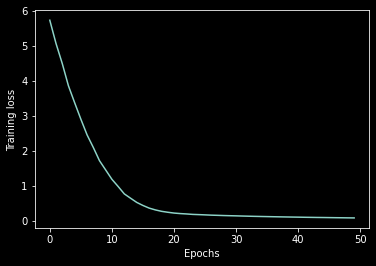

In [36]:
# Define the model parameters
input_size = train_dataset.X.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
epochs = 50

# Instantiate the model and the optimizer
model = ProfitPredictor(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

loss_data = []
# Train the model
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_data.append(train_loss)

plt.plot(range(epochs), loss_data)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

pred_df = pd.DataFrame()
# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_dataloader:
        y_pred_test = model(X_batch)
        test_loss += criterion(y_pred_test.squeeze(), y_batch).item()
        X_batch = X_batch.numpy()
        y_batch = y_batch.numpy()
        y_pred_test = y_pred_test.detach().numpy()

        # Extract the state information from the one-hot encoding
        states = ['California', 'Florida', 'New York']
        state_idx = np.argmax(X_batch[:,3:6], axis=1)
        state = [states[i] for i in state_idx]

        # Add the results to the DataFrame
        batch_df = pd.DataFrame({'R&D Spend': X_batch[:,0], 'Administration': X_batch[:,1], 'Marketing Spend': X_batch[:,2], 'State': state, 'Profit': y_batch, 'Predicted': y_pred_test[:,0]})
        pred_df = pd.concat([pred_df, batch_df], ignore_index=True) 


# Results
Now that I've trained and tested the data with the optimal parameters, it looks like we get an R2 score of approximately 0.95. 

In [31]:
from sklearn.metrics import r2_score
display(pred_df)
r2 = r2_score(pred_df['Profit'], pred_df['Predicted'])
print(f'R2 score: {r2:.2f}')

,R&D Spend,Administration,Marketing Spend,State,Profit,Predicted
0,-0.199312,0.656489,-0.603517,Florida,-0.115493,-0.053420
1,-0.773820,-1.383122,-0.297583,Florida,-0.777094,-0.765211
2,0.279442,1.159837,-1.743127,California,0.269773,0.111597
3,-0.258074,-0.205629,-0.990357,New York,-0.302625,-0.334697
4,0.035370,0.821718,-0.635835,New York,-0.157367,-0.043505
5,-1.610433,-2.509409,-1.743127,Florida,-1.913212,-1.503323
6,0.460720,0.855666,0.591017,California,0.334771,0.466575
7,-1.600350,0.101254,-1.727400,Florida,-1.180082,-1.360597
8,0.402078,0.510179,0.343957,Florida,0.558749,0.644234
9,-0.226949,0.283924,-1.362450,Florida,-0.365524,-0.332923


R2 score: 0.95
